Time series는 temporal dimension을 가지고 있으며 financial data에서 가장 상징적 형태라 볼 수 있다. 
이번에는 신경망이 어떻게 Time series를 다루는지 볼 것이고 dl 모델이 어떻게 불확실성을 표현할 수 있는지 볼 것이다.

Time series에 들어가기 앞서 대부분 주식 시장 예측이라는 주제를 기대하겠지만 이책에서는 해당 주제를 다루지 않을 것이다.  경제학에서 시장은 효율적이다. 효율적 시장 가설은 모든 대중이 주가와 관련된 정보를 이용할 수 있다고 주장한다. 이 내용은 예측 알고리즘이 어떻게 정보를 다뤄야하는지에 대한 것으로 이어진다. 

만약 이 책에서 수익 모델을 만든다면 많은 투자자들은 이 알고리즘을 구현할 것이다. 이 알고리즘으로 인해 시장 예측에 관한 모든 변수가 바뀐다. 그렇기에 이 책에서 제시한 알고리즘이 앞으로 읽을 독자들에게는 먹히지 않을 것이다.

대신에 이 챕터에서는 위키피디아에서 트래픽 데이터를 사용할 것이다. 우리의 목표는 특정 위키피디아 페이지의 트래픽을 예측하는 것이다. wikipediatrend CRAN package에서 위키피디아 트래픽 데이터를 구할 수 있다.

여기에서 쓸 데이터셋은 145000여개의 위키피디아 페이지가 있다. 데이터를 캐글에서 구할 수 있다.

데이터셋 링크:www.kaggle.com/c/web-traffic-time-series-forecasting

### Visualization and preparation in pandas

Applying Machine Learning to Structured Data에서 봤듯이, 학습 전에 데이터를 살펴보는 것이 좋다. 

In [2]:
import numpy as np
import pandas as pd

import os

In [3]:
print(os.listdir("../input"))

['key_1.csv', 'key_2.csv', 'sample_submission_1.csv', 'sample_submission_2.csv', 'train_1.csv', 'train_2.csv']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [5]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

In [6]:
train = pd.read_csv('../input/train_1.csv').fillna(0)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


첫번째 row에는 2NE1을 볼 수 있다. 더 유용한 features를 얻기 위해 string을 더 작게 parsing한다.

In [7]:
def parsing_page(page):
    x = page.split('_')
    return ' '.join(x[:-3]), x[-3], x[-2], x[-1]

언더스코어로 문자열을 나눴다. 

In [8]:
parsing_page(train.Page[0])

('2NE1', 'zh.wikipedia.org', 'all-access', 'spider')

트레이닝 셋의 모든 페이지에 적용할 때 튜플리스트를 얻을 수 있고 데이터프레임을 합칠 수 있다.

In [9]:
l =list(train.Page.apply(parsing_page))
df = pd.DataFrame(l)
df.columns = ['Subject', 'Sub_Page', 'Access', 'Agent']
df.head()

,Subject,Sub_Page,Access,Agent
0,2NE1,zh.wikipedia.org,all-access,spider
1,2PM,zh.wikipedia.org,all-access,spider
2,3C,zh.wikipedia.org,all-access,spider
3,4minute,zh.wikipedia.org,all-access,spider
4,52 Hz I Love You,zh.wikipedia.org,all-access,spider


In [10]:
train = pd.concat([train,df],axis=1)
del train['Page']

이제 본격적으로 데이터 탐색에 들어간다.

### Aggregate global feature statistics

pandas의 value_count() 함수는 global feature의 분포를 plot해준다. 

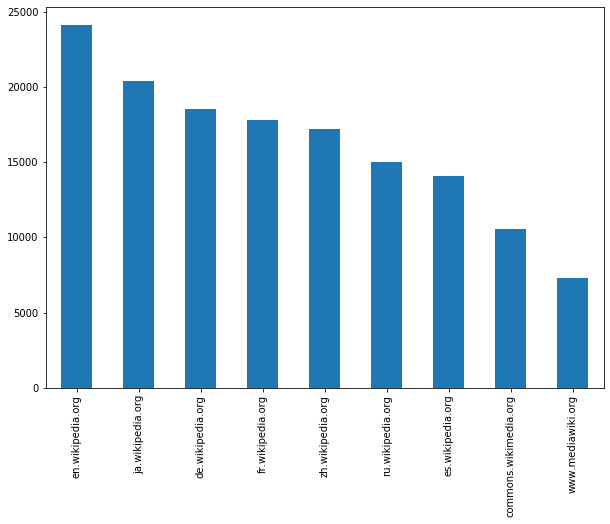

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
train.Sub_Page.value_counts().plot(kind='bar')

plot은 각 sub page 시계열의 수를 보여준다. 위키피디아는 다른 언어로 된 서브 페이지를 가지고 있다. 
이제 Access에 초점을 두고 다시 실행해본다.

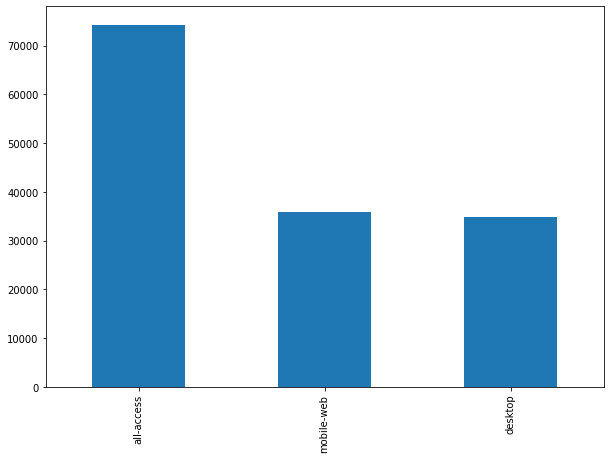

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))
train.Access.value_counts().plot(kind='bar')

모바일과 데스크탑 두가지의 접근할 수 있는 방법이 있다. 세번째 방법으로 all_access또한 있는데 모바일과 데스크탑을 합친 것이다. 

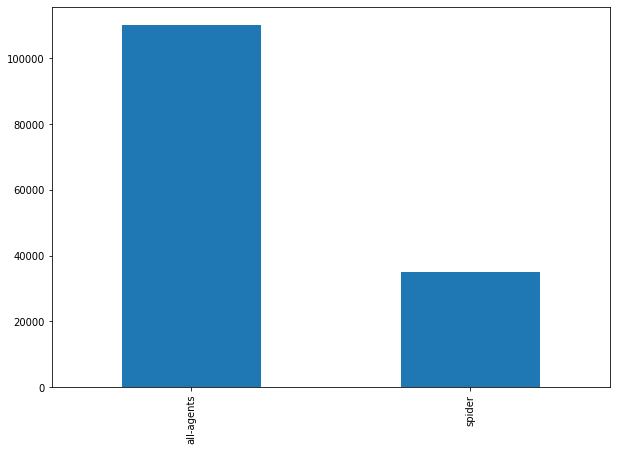

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
train.Agent.value_counts().plot(kind='bar')

스파이더 Agent뿐만 아니라 access의 all other 타입도 있다. 전통적인 통계 모델링에선 각 글로벌 feature들의 effect를 분석하고 모델을 만들었을 것이다. 그러나 데이터가 많고 컴퓨팅 파워가 충분하면 필요없다.

이러한 경우라면 neural network는 global feature의 effect를 찾을 수 있고 그들의 interaction 속에서 새로운 features를 생성할 수 있다. 

두가지 고려사항이 있다.

1. feature의 분포가 skewed 되었나?
2. feature가 쉽게 encoded될 수 있나?

어떤 global features는 one-hot encoded되지 않는다. 위키피디아 article의 전체 데이터셋의 시계열을 생각해보면 바로 사용하는 것은 불가능하다는 것을 알 수 있다. 

### Examining the sample time series 

데이터셋을 검사해보자.
10-day rolling mean의 page view를 plot하기 위해 아래의 코드가 필요하다.

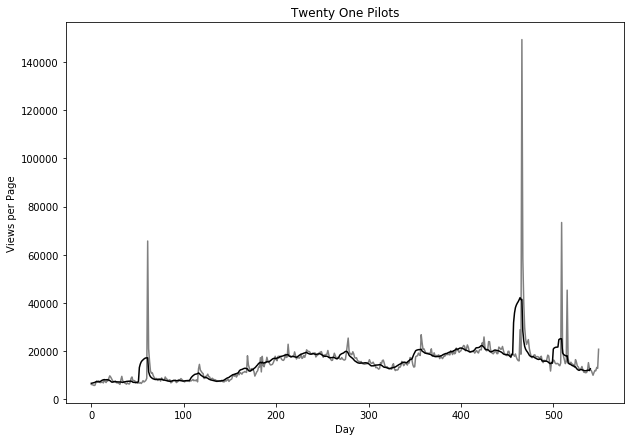

In [14]:
from matplotlib import dates

idx = 39457

window = 10


data = train.iloc[idx,0:-4]
name = train.iloc[idx,-4]
days = [r for r in range(data.shape[0] )]

fig, ax = plt.subplots(figsize=(10, 7))

plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title(name)

ax.plot(days,data.values,color='grey')
ax.plot(np.convolve(data, np.ones((window,))/window, mode='valid'),color='black')

평균을 계산하기 위해 convolve 연산을 사용했다.

모든 언어에서 Twenty One Pilots를 plot해보자.

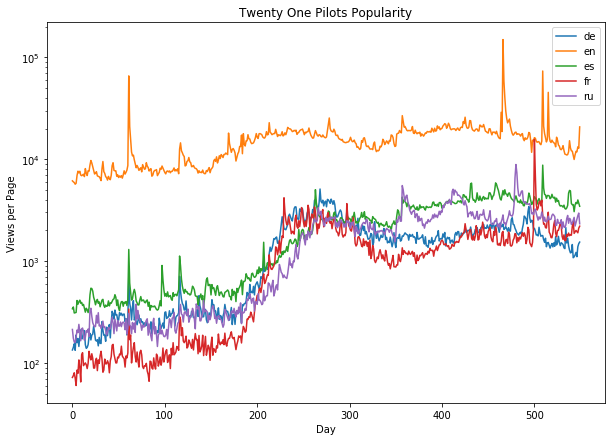

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Twenty One Pilots Popularity')
ax.set_yscale('log')
handles = []
for country in ['de','en','es','fr','ru']:
    idx= np.where((train['Subject'] == 'Twenty One Pilots') 
                  & (train['Sub_Page'] == '{}.wikipedia.org'.format(country)) 
                  & (train['Access'] == 'all-access') & (train['Agent'] == 'all-agents'))
    idx=idx[0][0]
    
    data = train.iloc[idx,0:-4]
    handle = ax.plot(days,data.values,label=country)
    handles.append(handle)

ax.legend()

시계열 간의 상관성을 볼 수 있다. 평균과 표준편차가 시간에 따라 바뀌고 있다. 200-250쯤에 평균이 급격하게 변하는 것을 볼 수 있다.

금융 분야의 시계열은 stationary하지 않다. stationary하지 않은 데이터를 다루는데 도움을 주는 몇가지 유용한 툴을 이 문제를 통해서 알아가보도록 한다.

### Why stationarity matters

많은 전통적인 경제학적 방법은 정상성을 가정한다. 이러한 이유는 추론과 가설의 테스팅이 정상성에서 더 잘 맞기 때문이다. 신경망을 사용하기 전에 데이터를 표준화시킬 필요가 있다. 주가가 1달러에서 1000달러가 됐다면 비정상시계열 데이터이고 학습하기에 매우 까다롭다. 

### Making a time series stationary

차분을 통해서 금융 데이터를 stationary로 만들 수 있다.

또 다른 방법으로 linear regression이 있다. 아래의 코드는 데이터로부터 linear trend를 없애는 것을 보여준다.

In [16]:
import statsmodels.api as sm

time = np.linspace(0, 10, 1000)
series = time
series = series + np.random.randn(1000) * 0.2
mdl = sm.OLS(time, series).fit()
trend = mdl.predict(time)

### When to ignore stationarity issues

정상성을 걱정하지 않아도 될 때가 있다. 급격한 변화를 예측할 때 이다. 예를 들어, 이전보다 위키피디아에 방문자가 그전보다 늘어나면 흥미가 증가한다고 볼 수 있다. 이러한 경우 difference를 제거하면 이러한 변화를 학습하지 못한다. 특정 비정상성은 변화를 감지하기 위해 남겨둬야 한다. 예측은 추론과 가설보다 정상성에 있어 덜 빡빡하다. 

### Fast Fourier transformations

시계열에 대한 계산을 원할 때 또 다른 흥미로운 statistic은 Fourier transformation이다. 푸리에 변환은 함수에서 특정 주파수 내에서 진동의 양을 보여준다.

오래된 FM 라디오위의 tuner를 생각해볼 수 있다. tuner를 돌리면 다른 frequency를 찾는 것이다. 가끔식 특정 라디오 station의 시그널을 주는 frequency 찾을 수 있다. 푸리에 변환은 기본적으로 모든 frequency 스펙트럼을 스캔하고 어떤 frequency가 강한지 기록한다. 시계열의 관점에서 데이터의 periodic patterns을 찾을 때 유용하다.

7일 간격의 frequency가 강한 패턴을 가진다는 것을 찾았다고 한다면, 1주일 전 같은 날 traffic이 얼마나 많은지에 대한 지식이 우리 모델에 도움이 된다는 것을 의미할 것이다.

function과 푸리에 변환이 이산인 일일 측정의 경우 discrete fourier transform이라 부른다. 매우 빠른 알고리즘인 DFT는 Fast Fourier Transform이라고도 하는데, 과학 계산 분야에 중요한 알고리즘이다.

푸리에 변환이 어떻게 그리고 왜 작동하는지 아는 것은 범위를 벗어나기 때문에, 간략한 소개를 하고자 한다. 

function을 wire라고 상상해보자. wire를 가지고 한 point에 감는다. wire를 가지고 한 point를 감싸서, point 주변의 회전수가 신호의 주파수와 일치하도록 한다면, 모든 신호의 peak는 극의 한쪽에 있을 것이다. 이것은 wire의 무게 중심이 우리가 wire를 감싼 point에서 멀어진다는 것을 의미한다. 

수학에서, point를 감싸는 wrapping function은 g(n)과 $e^{-2\pi fn}$를 곱하면 되는데 여기서 $f$는 wrapping의 frequency이고 n은 series의 아이템 수이고 i는 제곱해서 -1이 되는 허수이다. 

무게 중심을 계산하기 위해서, 이산 함수에서 point의 좌표를 average한다. DFT 공식은 아래와 같다.

$y[f] = \sum_{n=0}^{N-1} e^{-2\pi {fn \over N}} x[n]$

여기서 $y[f]$은 transformed series에서 fth째 요소이고, $x[n]$은 input series의 nth번째 요소이다. N은 input series의 전체 point의 수이다. $y[f]$는 실제 요소와 이산 요소를 가진 숫자가 될 것이다. 

주파수를 측정하기 위해 $y[f]$의 overall magnitude에만 주목할 필요가 있다. magnitude를 얻기 위해 실수와 허수에 대한 root of sum of square를 계산하면 된다. 

In [17]:
from scipy.fftpack import fft 

In [18]:
#idx = 39457
data = train.iloc[:,0:-4]
fft_complex = fft(data)

In [19]:
fft_complex.shape

(145063, 550)

In [20]:
fft_mag = [np.sqrt(np.real(x)*np.real(x)+
                   np.imag(x)*np.imag(x)) for x in fft_complex]

처음에 트레이닝셋에서 global features없이 time series measurements를 추출하였다. 그 후 FFT 알고리즘을 실행했다.

코드를 실행 후 모든 타임 시리즈 데이터셋에 대해 푸리에 변환이 있다. 푸리에 변환의 general behavior에 인사이트를 잘 얻기 위해 평균을 구할 수 있다.

In [21]:
arr = np.array(fft_mag)
fft_mean = np.mean(arr, axis=0)

우리는 모든 magnitude 평균값을 원하는게 아니라 frequency 마다 평균을 계산하기를 원한다. 그러므로 axis를 특정할 필요가 있다.

테스트를 해본다.

In [22]:
fft_mean.shape

(550,)

In [23]:
fft_xvals = [day / fft_mean.shape[0] for day in range(fft_mean.shape[0])]

In [24]:
npts = len(fft_xvals) // 2 + 1
fft_mean = fft_mean[:npts]
fft_xvals = fft_xvals[:npts]

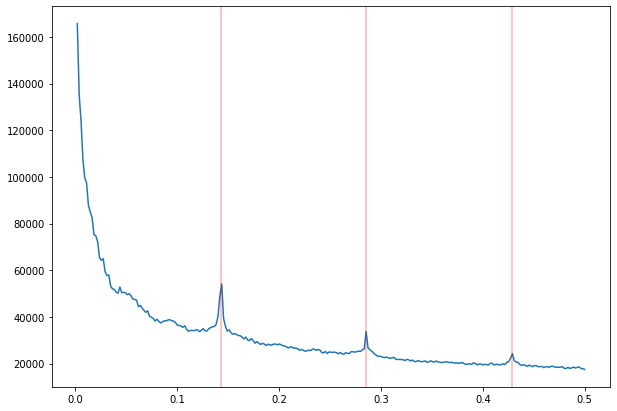

In [25]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(fft_xvals[1:],fft_mean[1:])
plt.axvline(x=1./7,color='red',alpha=0.3)
plt.axvline(x=2./7,color='red',alpha=0.3)
plt.axvline(x=3./7,color='red',alpha=0.3)

### Autocorrelation

Autocorrelation은 주어긴 간격에 의해 분리된 두 series 사이의 correlation이다. 그전 스텝은 다음 스텝을 예측하는데 도움이 될 수 있다고 생각할 수 있다. 그러나 두번째 전 스텝 또는 100째 전 스텝을 어떨까?

autocorrelation_plot은 이 질문에 대한 해답을 plot한다. pandas는 간편한 plotting툴을 제공한다. 

In [26]:
from pandas.plotting import autocorrelation_plot

Text(0.5, 1.0, 'Oh My Girl zh.wikipedia.org')

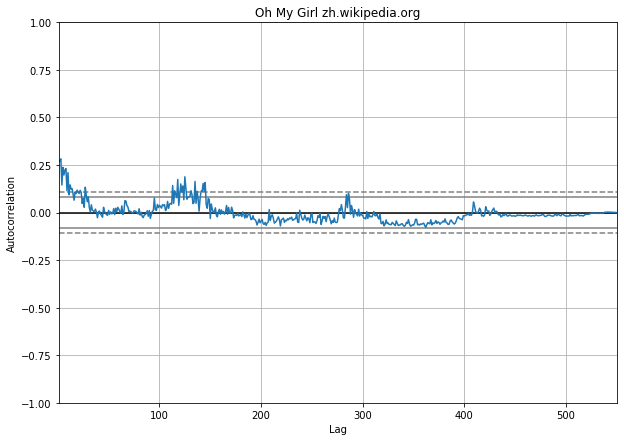

In [27]:
fig = plt.figure(figsize=(10, 7))

autocorrelation_plot(data.iloc[110])
plt.title(' '.join(train.loc[110,['Subject', 'Sub_Page']]))

오 마이 걸의 위키피디아 페이지 뷰의 correlation을 보여준다.

1에서 20days 사이의 짧은 시간 간격은 높은 상관관계를 보여준다. 120에서 280 사이에 호기심이 간다. 분기별, 반기별, 월별 이벤트가 오마이걸 위키피디아를 들어오게 만든다. 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:414: RuntimeWarning: invalid value encountered in double_scalars
  return ((data[: n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0


Text(0.5, 1.0, '1K Autocorrelations')

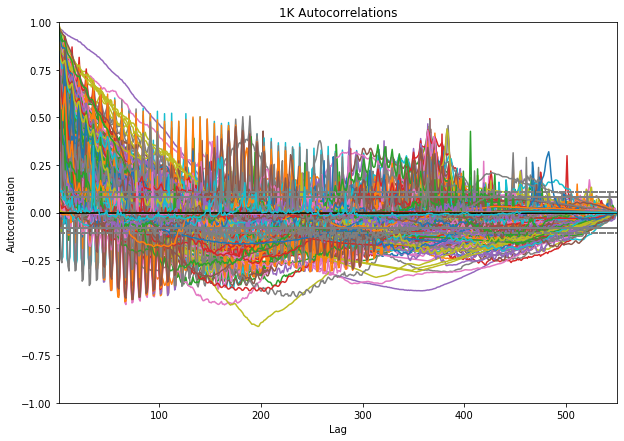

In [28]:
plt.figure(figsize=(10, 7))
a = np.random.choice(data.shape[0],1000)

for i in a:
    autocorrelation_plot(data.iloc[i])
    
plt.title('1K Autocorrelations')

다른 series에 따라 다른 상관관계를 보여준다. 그리고 general trend가 350days에 높은 상관관계를 나타내고 있다. 

시계열 분석은 모델의 feature 엔지니어링에 도움을 준다. 복잡한 신경망은 이러한 feature를 그들 스스로 찾아낸다. 그러나 시간의 기간이 길면 도움을 준다.

### Establishing a traning and testing regime

데이터의 양이 많더라도 검증 훈련 테스트 데이터셋을 어떻게 나눌지 생각해봐야 한다. 이 데이터셋은 이미 future data의 test set이 함께 제공된다. 그러므로 테스트셋은 걱정할 필요가 없다. 그러나 검증 데이터셋을 나눈는 방법으로 walk-forward split, side-by-side split이 있다. 

walk-forward split는 145000개의 모든 series를 훈련한다. 검증을 위해 모든 데이터에서 최근데이터를 더 많이 사용한다. side-by-side split에서는 샘플을 추출하고 나머지는 검증셋으로 사용한다.

둘다 이점과 단점이 있다. walk-forward split의 단점은 예측을 위해 series의 모든 관측을 쓸 수 없다는 것이다. side-by-side split은 모든 series를 훈련에 쓸 수 없다는 것이다. 

시리즈가 거의 없지만 시리즈당 여러 개의 데이터 관측치가 있는 경우 walk-forward가 선호된다. 시리즈가 많지만 시리즈당 적은 데이터 관측치가 있으면 side-by-side가 선호된다.

Establishing a traning and testing regime은 당면한 예측 문제와 더 잘 일치한다. side-by-side split는 predictiopn period에서 global event를 overfit할 수 있다.

글로벌 이벤트에 의해 prediction period가 영향을 받기 때문에 valid set에서 overfitting을 못 잡아낼 수 있다. 그러나 우리는 multiple time series를 가지고 있으며 관측수는 550개다. 그러므로 주어진 기간동안 영향을 주는 global event가 없을 것이다. 

그러나, 동계 올림픽과 같은 그로벌 이벤트가 있을 수 있다. 

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
data.shape

(145063, 550)

In [31]:
data

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,13.0,12.0,13.0,3.0,5.0,10.0
145059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
X = data.iloc[:,:500]
y = data.iloc[:,500:]

In [33]:
X

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-11-02,2016-11-03,2016-11-04,2016-11-05,2016-11-06,2016-11-07,2016-11-08,2016-11-09,2016-11-10,2016-11-11
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,18.0,25.0,14.0,20.0,8.0,67.0,13.0,41.0,10.0,21.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,11.0,14.0,26.0,11.0,21.0,14.0,14.0,54.0,5.0,10.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,3.0,3.0,3.0,2.0,10.0,2.0,2.0,2.0,7.0,3.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,12.0,11.0,15.0,7.0,12.0,13.0,9.0,8.0,21.0,16.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,6.0,33.0,13.0,10.0,22.0,11.0,8.0,4.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X.shape

(145063, 500)

In [35]:
y.shape

(145063, 50)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X.values, y.values, 
                                                  test_size=0.1, 
                                                  random_state=42)

In [37]:
X.values

array([[18., 11.,  5., ..., 41., 10., 21.],
       [11., 14., 15., ..., 54.,  5., 10.],
       [ 1.,  0.,  1., ...,  2.,  7.,  3.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

이 예제에서 우리는 loss와 evaluation metric으로 mean absolute percentage error를 사용한다. MAPE division vy zero에러를 만들 수 있기 때문에 아주 작은값 epsilon을 y에 더해준다.

In [38]:
def mape(y_true,y_pred):
    eps = 1
    err = np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100
    return err

### A note on backtesting

training과 testing 셋을 선택하는 특성은 알고리즘 트레이딩에서 특히 중요하다. 알고리즘을 테스트하는 가장 주요한 방법은 backtesting이라 부른다. 

Backtesting은 특정 시간의 기간의 데이터에 알고리즘을 훈련하고 과거 데이터에서 훈련시키는 것을 말한다. 예를 들어 2015에서 2018까지의 데이터를 가지고 훈련하고 1990에서 2015에 테스트할 수 있다. 이렇게 함으로 모데의 정확도 뿐만 아니라 백테스트된 알고리즘으로 가상의 트레이디을 통하여 수익률을 측정할 수 있다.

Backtesting은 특정 편향을 가지고 있는데 우리가 알아야 할 4가지 중요한 편향에 대해 살펴본다.

Look-ahead bias: 당시 쉽게 사용할 수 없었던 데이터를 해당 기간의 시뮬레이션에 사용하는 경우 발생. 투자자가 거래 전략의 성과를 Backtesting하고 있다면, 그들은 Look-ahead bias을 피하기 위해 거래 당시에 이용 가능했을 정보만을 사용하는 것이 필수적이다.

Survivorship bias: 시뮬레이션에서 테스트할 때 포함된 주식만 있는 경우를 말한다. 예를 들어 2008 금융 위기에 많은 은행이 파산했다. 2018에 simulator를 만들 때 이 기업을 빼면 survivorshil bias가 나타난다. 이 알고리즘은 2008에 그 주식을 사라고 나왔다. 

Psychological tolerance bias: 백테스트때 좋아 보이는 것이 실제로 좋아 보이지 않을 수 있다. 4개월 동안 손해를 보는 알고리즘이 있다고 할 때 이 알고리즘에 대해 만족할 수도 있다. 그러나 실제로 4개월 연속으로 손해를 보면, 우리는 가만히 앉아 있지 못할 수 있다. 백테스트에서는 마지막 결과를 알지만 실제 상황에서는 우리는 알 수 없다.

Overffiting: 이 문제는 모든 머신러닝 알고리즘에 있다. 그러나 백테스트에선 오버피팅은 다루기 쉽지 않다. 알고리즘 설계자는 과거에 대한 지식을 사용하여 테스트에서 훌륭해 보이는 과적합된 알고리즘을 구축할 수 있다. 

### Median forecasting

medians은 고소평과된 예측 툴이다. median은 노이즈를 제거하는데 탁월하다. 평균보다 이상치에 덜 민감하다. 중앙값을 찾는 것은 계산도 쉽다. 

예측을 하기 위해 트레이닝 데이터에서 look-back window를 통해 중위수를 계산한다. 우리는 window size로 50을 썼다. 그러나 다른 값을 탐색할 수 있다. X values에서 마지막 50개의 값을 선택하고 중위수를 계산한다. 

In [42]:
lookback = 50
lb_data = X_train[:,-lookback:]
med = np.median(lb_data,axis=1,keepdims=True)
err = mape(y_train,med)

In [43]:
err

68.1061532742806

68.1퍼센트의 error를 반환한다. 간단한 것 치곤 나쁘지 않다. 중위수가 어떻게 동작하는지 보려면, X values를 plotting하면 된다. y는 true value이다. random 페이지에 대해서 예측해보자.

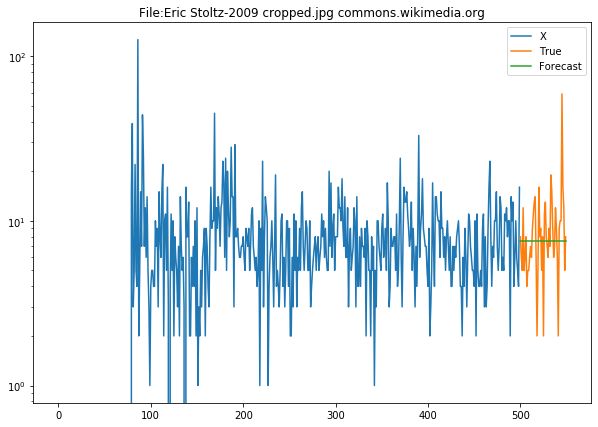

In [44]:
idx = 15000

fig, ax = plt.subplots(figsize=(10, 7))


ax.plot(np.arange(500),X_train[idx], label='X')
ax.plot(np.arange(500,550),y_train[idx],label='True')

ax.plot(np.arange(500,550),np.repeat(med[idx],50),label='Forecast')

plt.title(' '.join(train.loc[idx,['Subject', 'Sub_Page']]))
ax.legend()
ax.set_yscale('log')

중위수 예측으로 볼 수 있듯이, 중위수는 트렌드가 불명확하고 빈도수가 일정하지 않을 때 유용하다. 이게 중위수의 전부는 아니다. weekends에 다른 중위수를 사용할 수 있고, multiple look-back period에 중위수의 중위수를 사용할 수도 있다. 중위수는 feature engineering에 훌륭한 툴이다. 

### ARIMA

시계열 예측에 있어 seasonality와 stationarity의 중요성을 다뤘다. median forcasting은 두가지를 다루는데 있어 문제가 있다. 만약 시계열의 쳥균이 계속해서 shift된다면 median forcasting은 추세를 이어가지 않을 것이다. 그리고 시계열이 cyclical behavior를 보인다면, median은 cycle을 이어가지도 못한다.

ARIMA는 Autoregreesive Intergrated Moving Average의 약자로 세개의 핵심 구성요소로 만들어져 있다.

Autoregression: 모델은 lagged ovservation의 number와 값 사이의 관계를 사용한다.

Intergrated: raw observation의 차이를 사용하여 시계열의 stationary를 만든다. Point간의 차이가 항상 같기 때문에 계속 상승하는 시계열은 평평한 intergral를 가질 것이다.

Moving Average: 모델이 이동평균의 residual error를 사용한다.

우리는 수동으로 얼마나 lagged observation을 포함시킬지 얼마나 차분할 것인지, 얼마만큼 이동평균을 쓸 것인지 정해야 한다. 위 세가지를 포함하여 ARIMA는 linear regression을 수행한다. 

In [45]:
from statsmodels.tsa.arima_model import ARIMA

In [46]:
model = ARIMA(X_train[0], order=(5,1,5))

In [47]:
model = model.fit()

In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  499
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -3864.353
Method:                       css-mle   S.D. of innovations            554.901
Date:                Sun, 02 Aug 2020   AIC                           7752.705
Time:                        16:28:57   BIC                           7803.257
Sample:                             1   HQIC                          7772.543
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0502     15.544      0.196      0.845     -27.415      33.515
ar.L1.D.y     -0.0930      0.040     -2.335      0.020      -0.171      -0.015
ar.L2.D.y     -0.6624      0.033    -20.100      0.000      -0.727      -0.598
ar.L3.D.y     -0.5104      0.052     -9.781      0.000      -0.613      -0.408
ar.L4.D.y     -0.2225      0.032     -6.913      0.000      -0.286      -0.159
ar.L5.D.y     -0.8554      0.040    -21.494      0.000      -0.933      -0.777
ma.L1.D.y     -0.1237      0.052     -2.364      0.018      -0.226      -0.021
ma.L2.D.y      0.3654      0.044      8.278      0.000       0.279       0.452
ma.L3.D.y      0.4518      0.051      8.812      0.000       0.351       0.552
ma.L4.D.y     -0.2619      0.045     -5.789      0.000      -0.351      -0.173
ma.L5.D.y      0.6590      0.045     14.766      0.000       0.572       0.746
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6363           -0.7875j            1.0124           -0.1418
AR.2            0.6363           +0.7875j            1.0124            0.1418
AR.3           -1.0942           -0.0000j            1.0942           -0.5000
AR.4           -0.2192           -0.9971j            1.0210           -0.2844
AR.5           -0.2192           +0.9971j            1.0210            0.2844
MA.1           -1.0230           -0.0000j            1.0230           -0.5000
MA.2           -0.0932           -1.0750j            1.0790           -0.2638
MA.3           -0.0932           +1.0750j            1.0790            0.2638
MA.4            0.8034           -0.7927j            1.1287           -0.1239
MA.5            0.8034           +0.7927j            1.1287            0.1239
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'ARIMA residuals for 2NE1 pageviews')

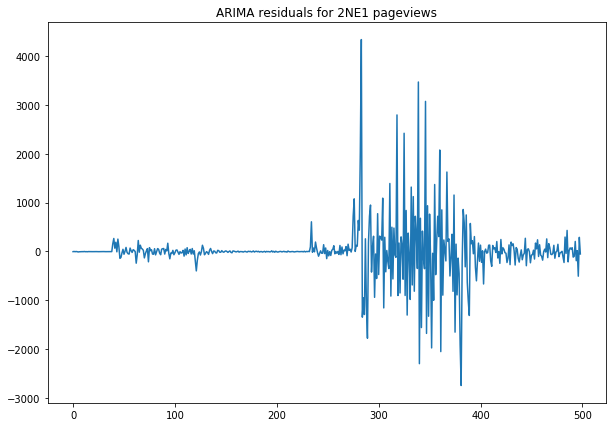

In [49]:
fig, ax = plt.subplots(figsize=(10, 7))
idx = 0
residuals = pd.DataFrame(model.resid)
ax.plot(residuals)

plt.title('ARIMA residuals for 2NE1 pageviews')

preceding chart에서 모델이 처음에는 잘 맞지만 300day부터 매우 struggle하는 것을 볼 수 있다. 이 기간 동안 변동성이 더 크거나 페이지 뷰를 예측하기 어렵다고 볼 수 있다. 

모델이 왜곡되지 않도록 하려면 잔차의 분포를 조사해야 한다. kernel density estimator(분포를 모델링할 필요 없이 설정하도록 설계된 수학적 방법)를 사용하면 된다. 




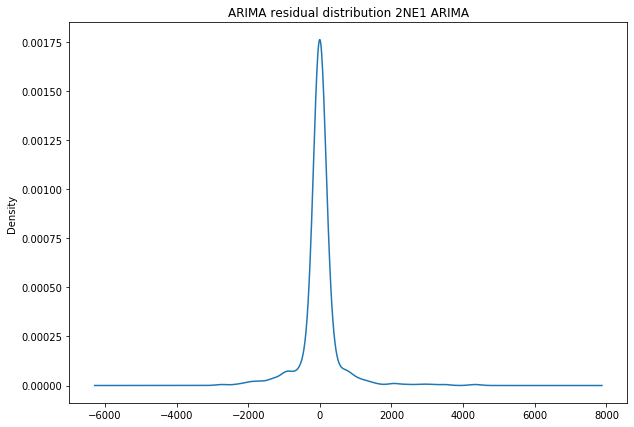

In [50]:
residuals.plot(kind='kde',
               figsize=(10,7),
               title='ARIMA residual distribution 2NE1 ARIMA', legend=False)

모델이 평균이 0인 가우시안 분포를 표현하는 것을 볼 수 있다. 

이 모델을 예측을 위해 사용하기 위해 우리가 예측하기 원하는 number of days를 specify해야 하는 것이다. 

In [51]:
predictions, stderr, conf_int = model.forecast(50)

이 예측은 예측 결과를 줄 뿐만 아니라, standard error와 confidence interval(기본값 95 설정된)을 준다.  

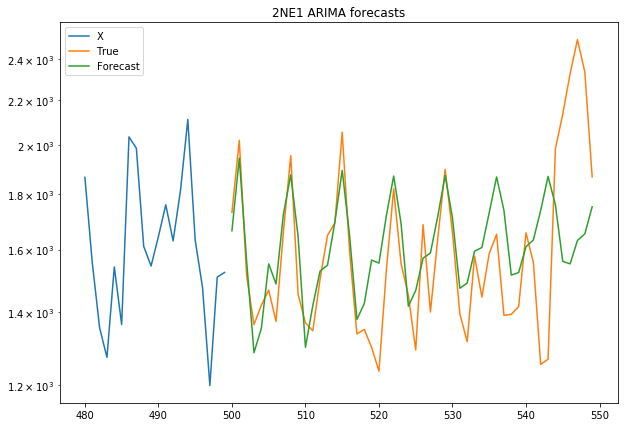

In [52]:
fig, ax = plt.subplots(figsize=(10, 7))


ax.plot(np.arange(480,500),X_train[0,480:], label='X')
ax.plot(np.arange(500,550),y_train[0],label='True')

ax.plot(np.arange(500,550),predictions,label='Forecast')


plt.title('2NE1 ARIMA forecasts')
ax.legend()
ax.set_yscale('log')

ARIMA는 시계열의 주기성을 매우 잘 캡쳐한다. 마지막에는 방향이 이상해지지만 처음에는 예측을 잘한다.

### Kalman filters

Kalman filters는 노이즈나 불완전한 측정에서 signal을 뽑아내는 방법이다. Kalman filters의 기본적인 아이디어는 우리가 직접적으로 관찰할 수 없는 hidden state가 있는데 noisy measurements를 통해 얻을 수 있다. 만일 로켓 엔진의 온도를 측정하길 원한다면 엔진에 직접적인 온도를 측정할 순 없을 것이다. 너무 뜨겁기 때문인데 엔진 밖에서 온도를 측정하는 장치가 있다면 가능할 것이다. 

당연히, 외부의 많은 factor들이 엔진 밖에서 발생하고 노이즈를 만들기 때문에 measurement는 완벽하지 않다. 그러므로 로켓안의 온도를 측정하기 위해, 노이즈를 다루는 방법이 필요하다. 페이지 예측의 내부 상태를 특정 페이지에 대한 실제 관심으로 생각할 수 있으며, 그 중 페이지 뷰는 noisy measurement만을 나타낸다.

여기서 아이디어는 시간 k에서 내부 상태 $x_k$가 이전 내부 상태 $x_{k-1}$와 일부 프로세스 노이즈 $q_{k-1}$를 곱한 상태 전이 행렬 A라는 것이다. 2NE1의 위키피디아 페이지의 관심이 어떻게 전재되는지는 어느 정도 random이다. 무작위성은 평균이 0이고 variance가 Q인 가우시안 정규 분포를 따른다고 가정한다.

$x_k = Ax_{k-1} + q_{k-1},      q_{k-1} \sim N(0, Q)$